# Experiment 2 Analysis

This notebook explores the results of re-running the experiments on larger datasets. This was necessary, as the difference in accuracy between algorithms is often a fraction of a percent. By using a test set of 100,000 datapoints, we can estimate accuracy of each run to a 95% confidence interval of ±0.3%.

We also re-run each variation of each algorithm 12 times on (up to 10) batches of 1,000 training points to explore variability arising from the training data. (Unlike testing, we don't want to eliminate variability by training on a large number of points, as the purpose of the experiment is to see if the algorithm can construct good trees given a small dataset)

## Load Experiment Output

The full set of experiments, generated by `experiment2.py`, takes 12 hours to run and uses 411 MB of disk space (in addition to 33.6 GB of disk space to extract the datasets from the UCI repository). This notebook just analyses the experiment output saved to the directory `out17`.

ChatGPT was used to assist in generating the data wrangling/visualisation code within this notebook.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re

In [2]:
# PROMPT: find all files matching ../out16/accuracy_*.csv, load them as dataframes and conatentate them
# PROMPT: ignore the first index column when loading the dataframes
# PROMPT: When loading the data use the filename pattern ../out16/accuracy_{dataset}_run_{runid}.csv. Include runid as a column
# PROMPT: Use good practices: match to a regex rather than hardcoding the index of runid
# (manual edits)

# Define the regex pattern to match filenames
pattern = r'../out17/accuracy_(?P<datafile>.*?)_run_(?P<runid>\d+)\.csv'

# Use the glob library to find all matching files
file_list = glob.glob('../out17/accuracy_*.csv')

# Initialize an empty list to store dataframes
dfs = []

# Loop through the files, load them as dataframes, and extract dataset and runid using regex
for file in file_list:
    match = re.match(pattern, file)
    if match:
        datafile = match.group('datafile')
        runid = match.group('runid')
        
        # Load the CSV file
        df = pd.read_csv(file, index_col=0)  # Specify index_col=0 to ignore the first index column
        
        # Add the runid as a new column in the dataframe
        df['runid'] = int(runid)
        df['datafile'] = datafile
        assert (df['dataset'] == df['datafile'] + '_run_' + df['runid'].astype("string")).all()
        
        # Append the dataframe to the list
        dfs.append(df)

# Concatenate all dataframes into a single dataframe
df = pd.concat(dfs, ignore_index=True)

# Now, final_df contains the concatenated data from all matching CSV files with the runid as a column


In [3]:
# PROMPT: alg follows the pattern {algoritm}_{alpha}_{beta} or just {algorithm}. Add columns for algorithm, alpha and beta. In that latter case, make alpha and beta to null

# Split 'alg' column
df['algorithm'] = df['alg'].apply(lambda x: x.split('_')[0])
df['alpha'] = df['alg'].apply(lambda x: int(x.split('_')[1]) if len(x.split('_')) > 1 else pd.NA)
df['beta'] = df['alg'].apply(lambda x: int(x.split('_')[2]) if len(x.split('_')) > 2 else pd.NA)

Some algorithms are just special cases of the keep-regrow algorithm:
* Keep-regrow with a very low beta parameter (i.e. no penalty for changes) is the same as re-training each batch
* Keep-regrow with a very high beta parameter (i.e. change highly penalised) is the same as keeping the original tree

For efficiency, rather than running these variants of keep-regrow, we just copy the results from the equivalent algorithms and add them to the dataframe as variants of keep-regrow 

In [4]:
# tree-retrain can be thought of as a special case of keep-regrow where we actively discard the regrown tree

# Find rows with 'algorithm' as 'tree-retrain'
tree_retrain_rows = df[df['algorithm'] == 'tree-retrain']

# Create duplicate rows with 'algorithm' as 'keep-regrow' and 'beta' as -100
duplicate_rows = tree_retrain_rows.copy()
duplicate_rows['alg'] = 'keep-regrow_' + duplicate_rows['alpha'].apply(str) + "_-100" 
duplicate_rows['algorithm'] = 'keep-regrow'
duplicate_rows['beta'] = -100

# Append the duplicate rows to the original dataframe
df = pd.concat([df, duplicate_rows], ignore_index=True)


In [5]:
# original tree can be thought of as a special case of keep-regrow with very high beta

# Find rows with 'algorithm' as 'keep-regrow' (just results for the first batch)
tree_retrain_rows = df[(df['algorithm'] == 'keep-regrow') & (df['batch'] == 1) & (df['beta'] == 1)]

for b in range(1, 10 + 1): # (if keeping the original tree, result for each batch will be the same)
    # Create duplicate rows with 'algorithm' as 'keep-regrow' and 'beta' as 100
    duplicate_rows = tree_retrain_rows.copy()
    duplicate_rows['alg'] = 'keep-regrow_' + duplicate_rows['alpha'].apply(str) + "_100" 
    duplicate_rows['batch'] = b
    duplicate_rows['beta'] = 100
    duplicate_rows['similarity'] = 1

    # Append the duplicate rows to the original dataframe
    df = pd.concat([df, duplicate_rows], ignore_index=True)


Data from all experiments, in a single data frame:

In [6]:
df

,alg,batch,acc,nodes,dataset,similarity,train-duration,test-duration,runid,datafile,algorithm,alpha,beta
0,efdt,1,0.71711,3,Susy_run_7,NaN,1.181325,1.189128,7,Susy,efdt,<NA>,NaN
1,efdt,2,0.71711,3,Susy_run_7,1.000000,1.414274,1.194086,7,Susy,efdt,<NA>,NaN
2,efdt,3,0.71711,3,Susy_run_7,1.000000,1.411941,1.195708,7,Susy,efdt,<NA>,NaN
3,efdt,4,0.75693,5,Susy_run_7,0.724912,1.514647,1.233011,7,Susy,efdt,<NA>,NaN
4,efdt,5,0.75738,7,Susy_run_7,0.979966,0.526073,1.254858,7,Susy,efdt,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18686,keep-regrow_5_100,10,0.79746,3,Hepmass_run_0,1.000000,0.126639,0.210645,0,Hepmass,keep-regrow,5,100
18687,keep-regrow_5_100,10,0.76389,13,Susy_run_10,1.000000,0.181020,0.429738,10,Susy,keep-regrow,5,100
18688,keep-regrow_5_100,10,0.66912,5,Cover_run_10,1.000000,0.429921,0.340087,10,Cover,keep-regrow,5,100
18689,keep-regrow_5_100,10,0.75362,9,Susy_run_2,1.000000,0.187021,0.407215,2,Susy,keep-regrow,5,100


In case of keep-regrow, there are multiple versions for the parameters by alpha and beta. In the case of tree-retrain, there are multiple versions for the parameter alpha:

In [7]:
df['alg'].unique()

array(['efdt', 'vfdt', 'keep-regrow_5_0', 'keep-regrow_5_1',
       'keep-regrow_5_2', 'keep-regrow_5_3', 'keep-regrow_5_4',
       'keep-regrow_5_5', 'keep-regrow_5_10', 'tree-retrain_1_0',
       'tree-retrain_2_0', 'tree-retrain_3_0', 'tree-retrain_4_0',
       'tree-retrain_5_0', 'tree-retrain_10_0', 'tree-retrain_20_0',
       'tree-retrain_30_0', 'keep-regrow_1_-100', 'keep-regrow_2_-100',
       'keep-regrow_3_-100', 'keep-regrow_4_-100', 'keep-regrow_5_-100',
       'keep-regrow_10_-100', 'keep-regrow_20_-100',
       'keep-regrow_30_-100', 'keep-regrow_5_100'], dtype=object)

## Exploration of Alpha Parameter

The alpha parameter controls the penalty for complex trees (measured in terms of the number of nodes). This can be thought of as a form of pruning (which is already well studied), but we need to select a value of alpha so we can proceed with the rest of the study.

The visualisations in this section explore the tradeoff between accuracy (on the test set) and number of nodes for different values of alpha. Ths small points show the results for each individual run, and the large points (outlined in black) show the average estimate across 12 runs for a particular variant of the algorithm. This is just for the first batch of data, so is just growing a traditional decision tree (using sklearn) then performing pruning (with the level controlled by alpha). The keep-regrow algorithm only comes into play on the second batch of data once we have an initial decision tree.

On the Skin dataset (consisting of just three dimensions) more nodes allows a better fit, but on other more complex datasets such as Higgs, we can see more nodes also leads to overfitting which lowers the accuracy on the test set.

Based on the results, we suggest a default value of alpha=5 to minimise the complexity of the tree and prevent overfitting.

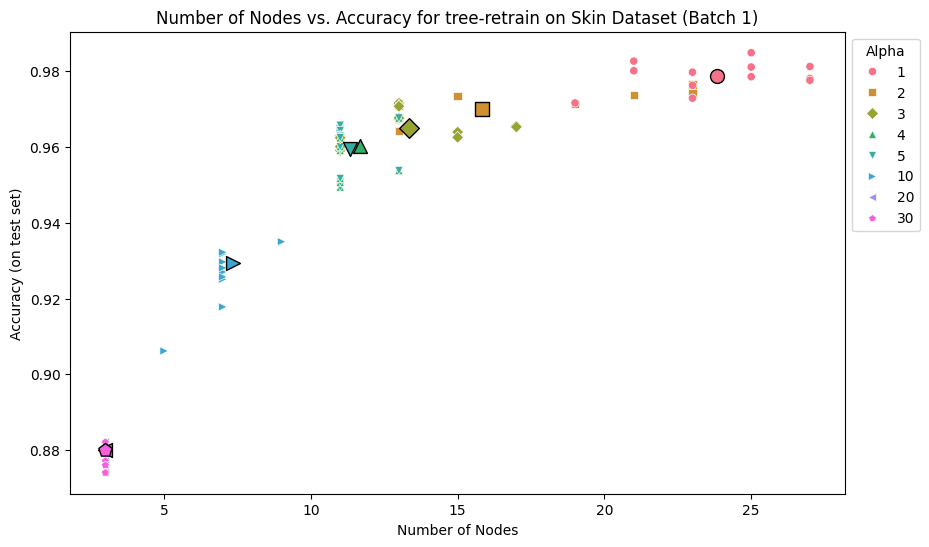

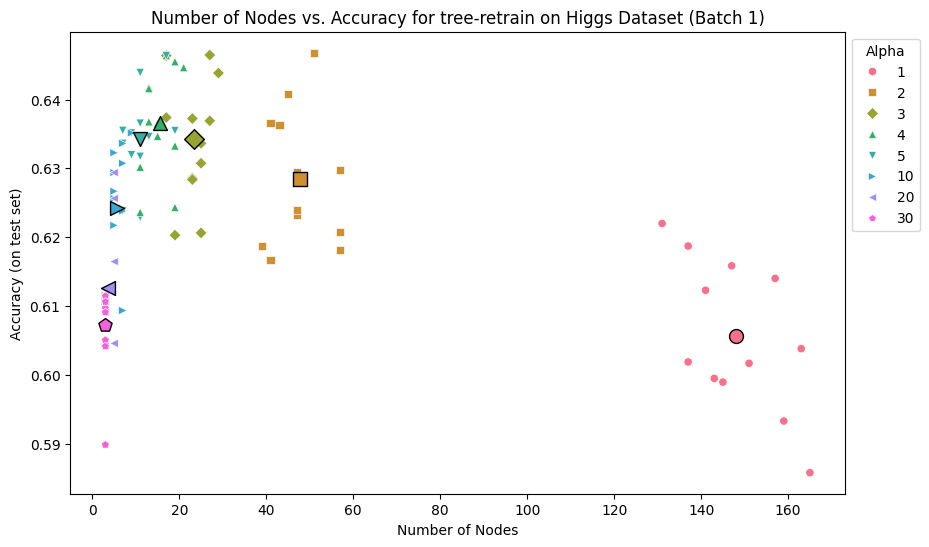

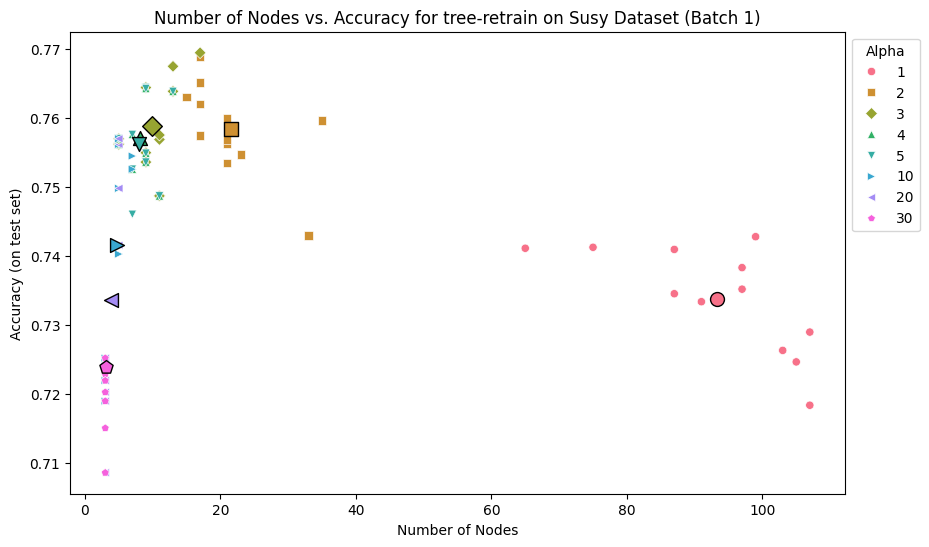

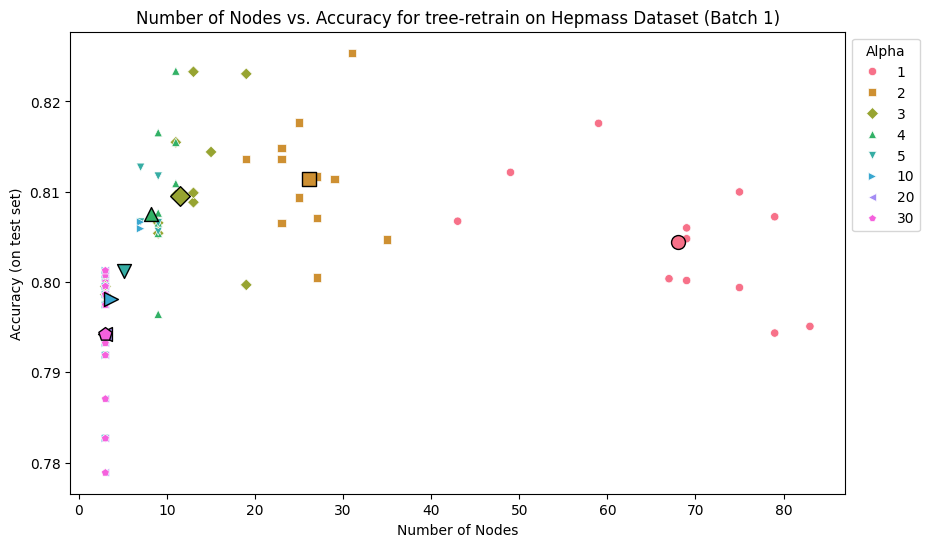

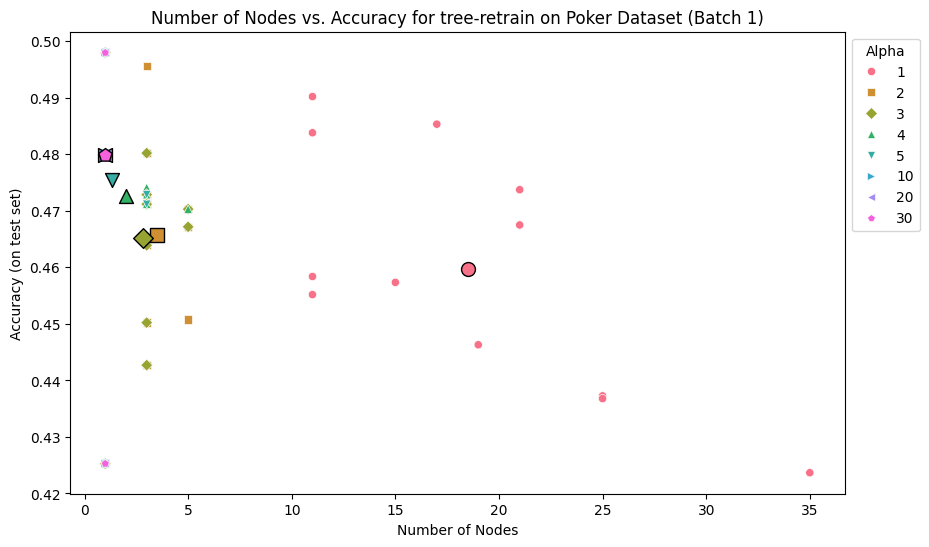

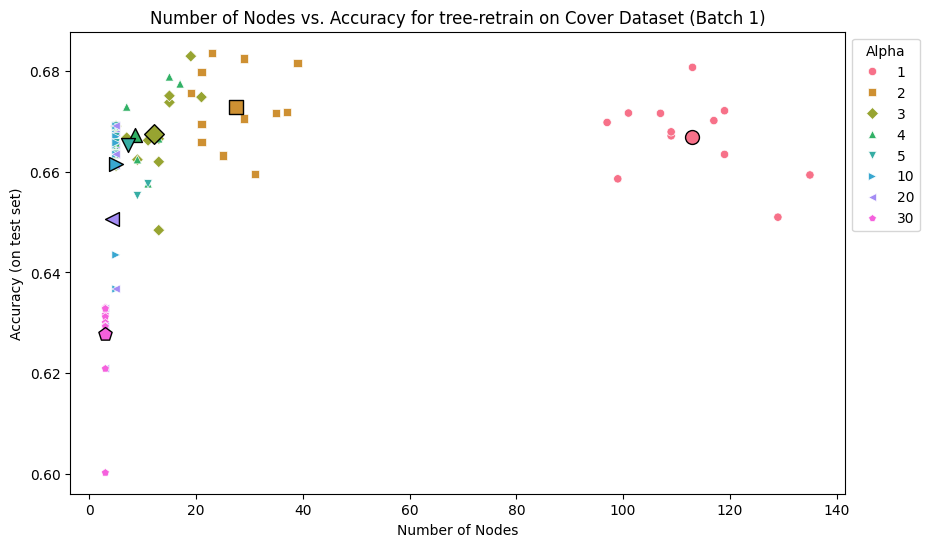

In [8]:
# Get unique datafile names
# unique_datafiles = df['datafile'].unique()
# Use the same order as generated
unique_datafiles = ['Skin', 'Higgs', 'Susy', 'Hepmass', 'Poker', 'Cover']

# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[(df['algorithm'] == 'tree-retrain') &
                     (df['datafile'] == datafile) &
                     #(df['beta'] == 0) & # beta ignored, so doesn't matter if 1 or 0
                     (df['batch'] == 1)
                    ]

    # Calculate the group averages
    grouped = filtered_df.groupby('alpha').agg({'acc': 'mean', 'nodes': 'mean'}).reset_index()

    # Create a custom palette with distinct colors
    custom_palette = sns.color_palette("husl", len(filtered_df['alpha'].unique()))

    # Create a custom list of markers for distinct symbols
    markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p']

    # Create the scatter plot with distinct colors and symbols
    plt.figure(figsize=(10, 6))
    sns.scatterplot(y='acc', x='nodes', hue='alpha', style='alpha', markers=markers, palette=custom_palette, data=filtered_df)
    plt.title(f'Number of Nodes vs. Accuracy for tree-retrain on {datafile} Dataset (Batch 1)')
    plt.ylabel('Accuracy (on test set)')
    plt.xlabel('Number of Nodes')
    plt.legend(title='Alpha', loc='upper left', bbox_to_anchor=(1, 1))

    # Plot the group averages as symbols
    for index, row in grouped.iterrows():
        plt.scatter(row['nodes'], row['acc'], marker=markers[index], s=100, color=custom_palette[index], edgecolor='black', linewidth=1)

    plt.show()


## Exploration of Beta Parameter

The beta parameter controls the penalty for changed nodes (if a branch node condition is changed, all nodes under it are also considered changed). The ability to prioritise a tree that is similar to the one learned from the previous batch is the novel aspect of the keep-regrow algorithm.

The visualisations in this section explore the tradeoff between accuracy (for batch 2, on the test set), number of nodes (for batch 2), and similarity (between the trees for batch 2 and batch 1) for different values of beta, at a fixed alpha.

Larger values of beta tend to result in decision trees with less nodes. This is because adding a new node results in the double penalty of both additional complexity penalised by alpha and additional changes penalised by beta.

Larger values of beta result in more similar trees, but comes at the cost of accuracy. We can see that retraining the tree (shown as beta=-100 as this is equivalent to not penalising changes) results in low similarity but high accuracy. Keeping the original treee (shown as beta=100 as this is equivalent to severely penalising change) results in 100% similarity, but no improvement in accuracy over the first batch. Beta allows us to produce trees that fall between these two extremes.

An interesting case is beta=0, which will preserve branches of the original tree if they don't result in any loss in accuracy on the training set compared to regrowing those branches. In most cases, this produces trees with a higher similarity to the original tree than retraining (beta=-100) but without sacrificing any accuracy.

Based on the results, we suggest a default value of beta=1 to penalise changes while minimising the loss of accuarcy. On the datasets, we can see that the drop in accuracy of keep-regrow with beta=1 compared to retraining a new decision tree (beta=-100) is only a fraction of a percent.

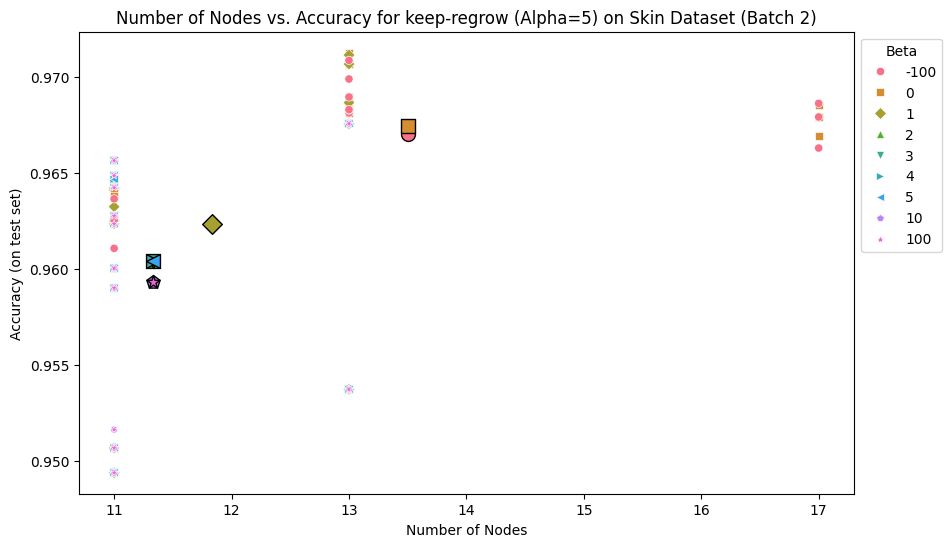

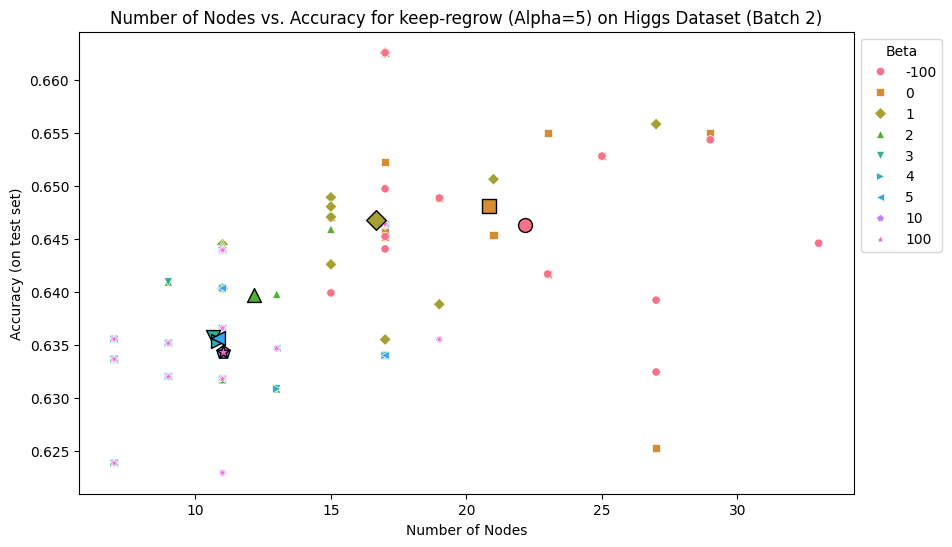

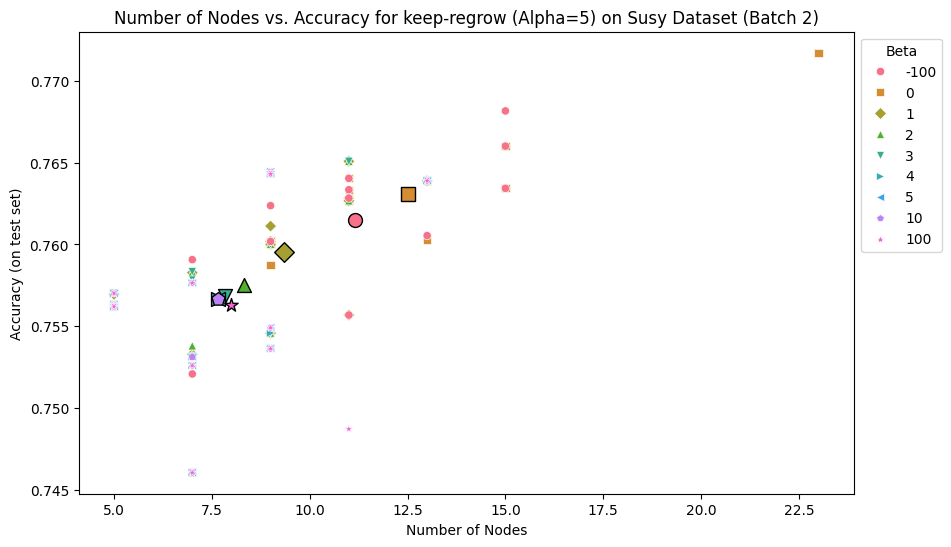

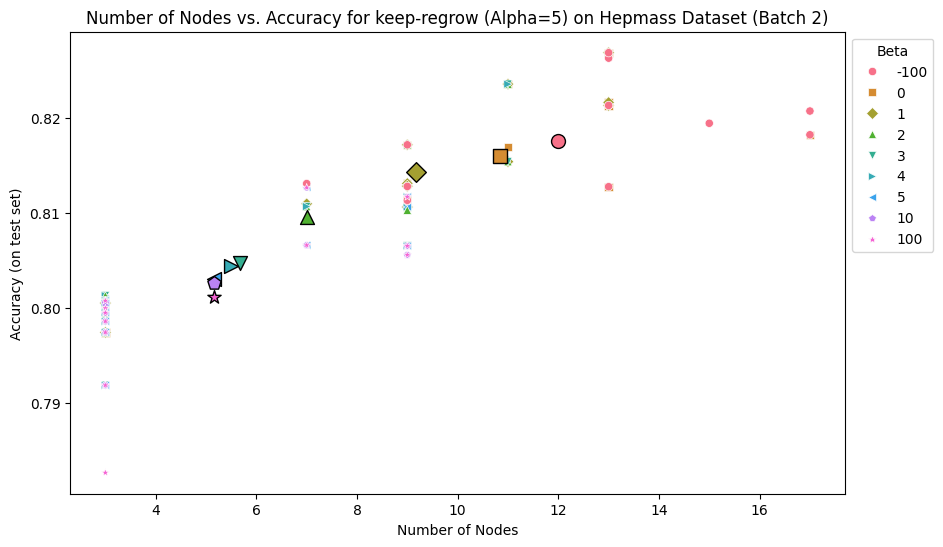

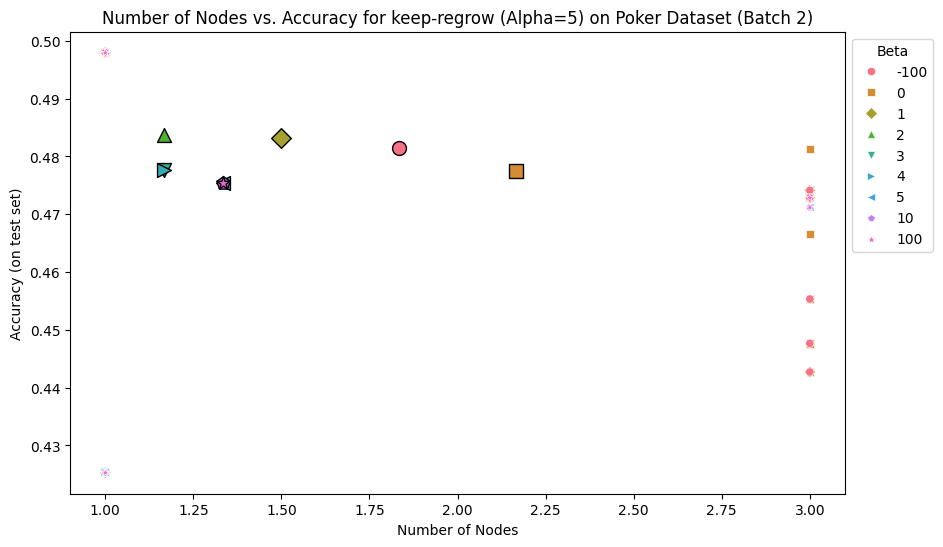

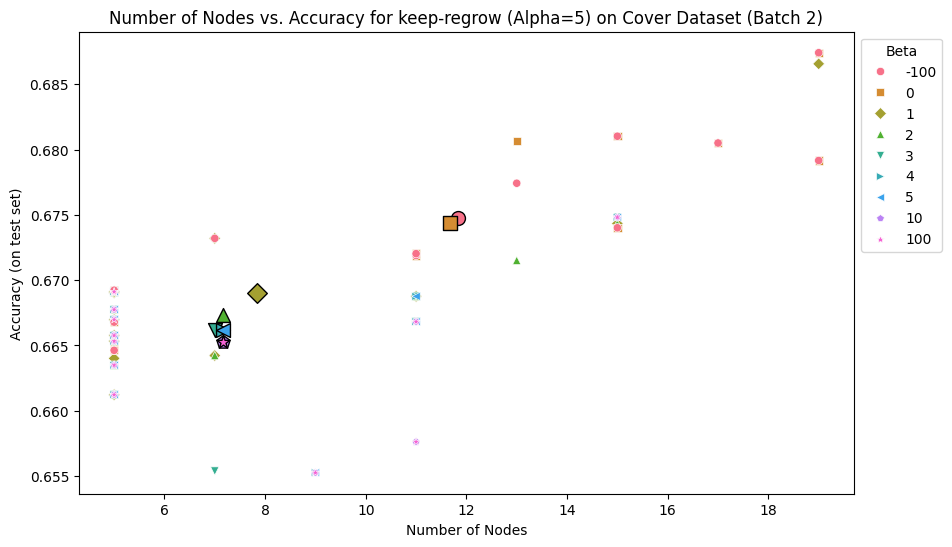

In [9]:
# Get unique datafile names
# unique_datafiles = df['datafile'].unique()
# Use the same order as generated
unique_datafiles = ['Skin', 'Higgs', 'Susy', 'Hepmass', 'Poker', 'Cover']

# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[(df['algorithm'] == 'keep-regrow') &
                     (df['datafile'] == datafile) &
                     (df['alpha'] == 5) &
                     (df['batch'] == 2)
                    ]

    # Calculate the group averages
    grouped = filtered_df.groupby('beta').agg({'acc': 'mean', 'nodes': 'mean'}).reset_index()

    # Create a custom palette with distinct colors
    custom_palette = sns.color_palette("husl", len(filtered_df['beta'].unique()))

    # Create a custom list of markers for distinct symbols
    markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*']

    # Create the scatter plot with distinct colors and symbols
    plt.figure(figsize=(10, 6))
    sns.scatterplot(y='acc', x='nodes', hue='beta', style='beta', markers=markers, palette=custom_palette, data=filtered_df)
    plt.title(f'Number of Nodes vs. Accuracy for keep-regrow (Alpha=5) on {datafile} Dataset (Batch 2)')
    plt.ylabel('Accuracy (on test set)')
    plt.xlabel('Number of Nodes')
    plt.legend(title='Beta', loc='upper left', bbox_to_anchor=(1, 1))

    # Plot the group averages as symbols
    for index, row in grouped.iterrows():
        plt.scatter(row['nodes'], row['acc'], marker=markers[index], s=100, color=custom_palette[index], edgecolor='black', linewidth=1)

    plt.show()


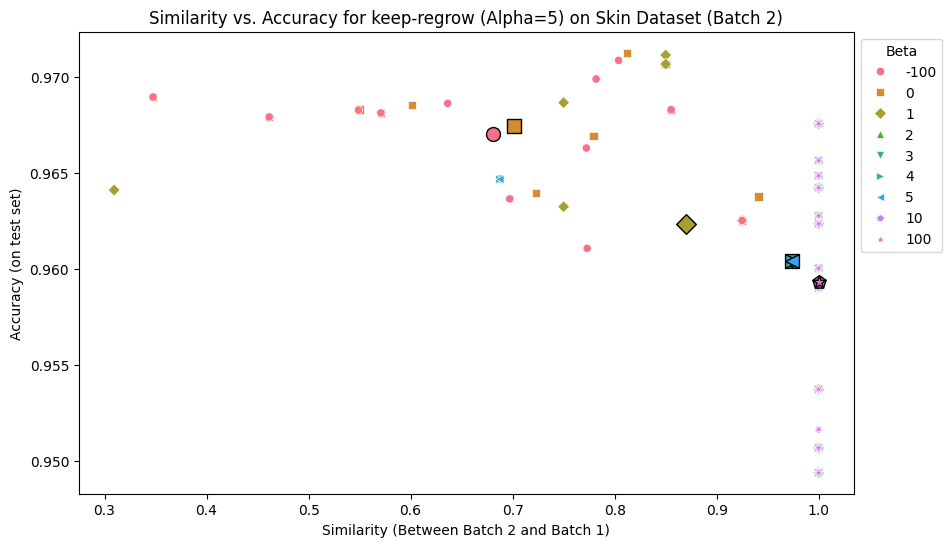

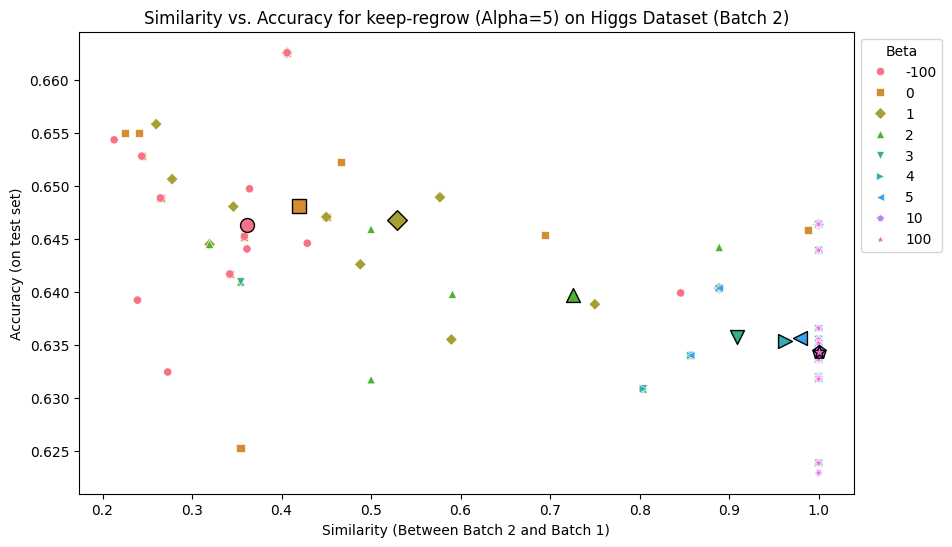

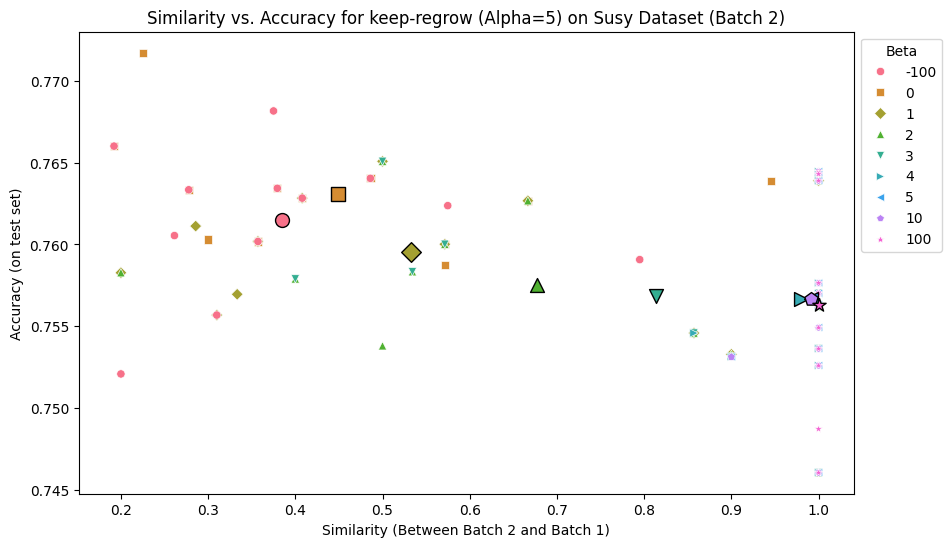

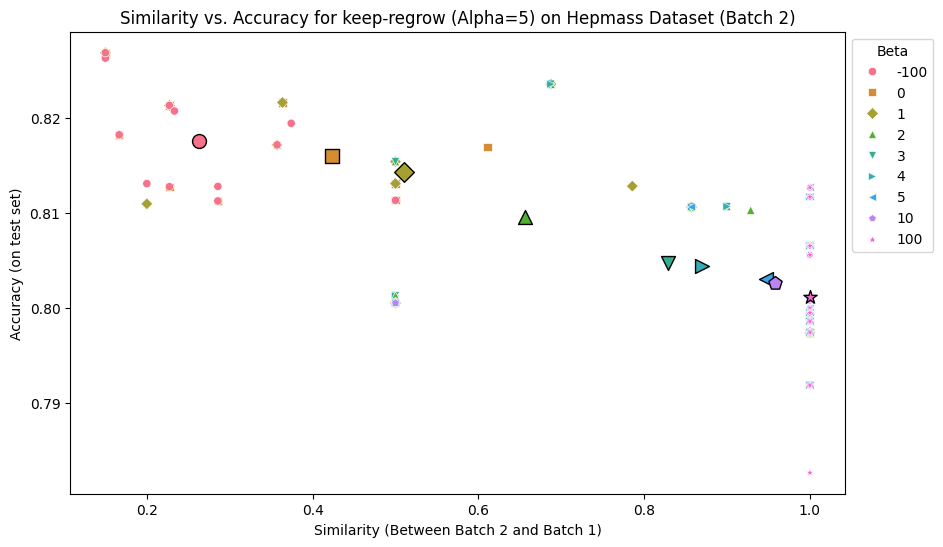

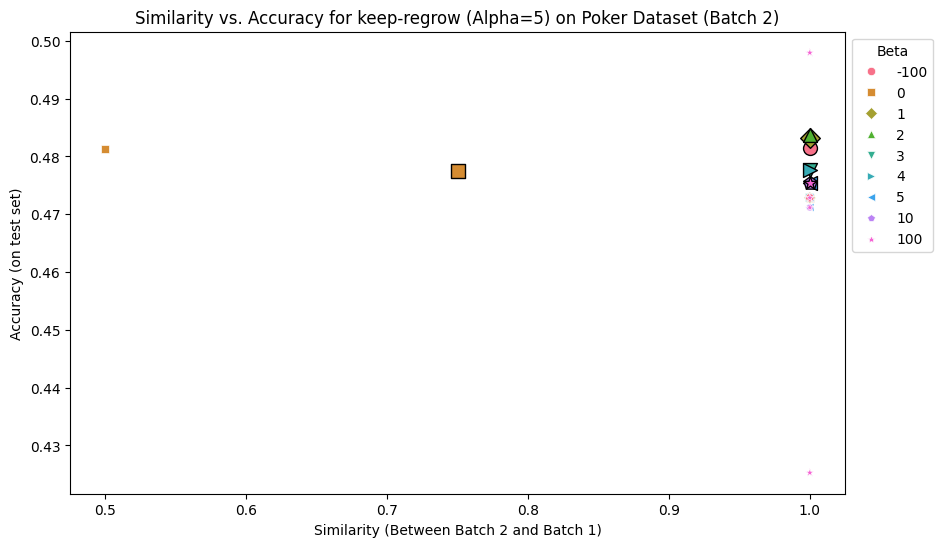

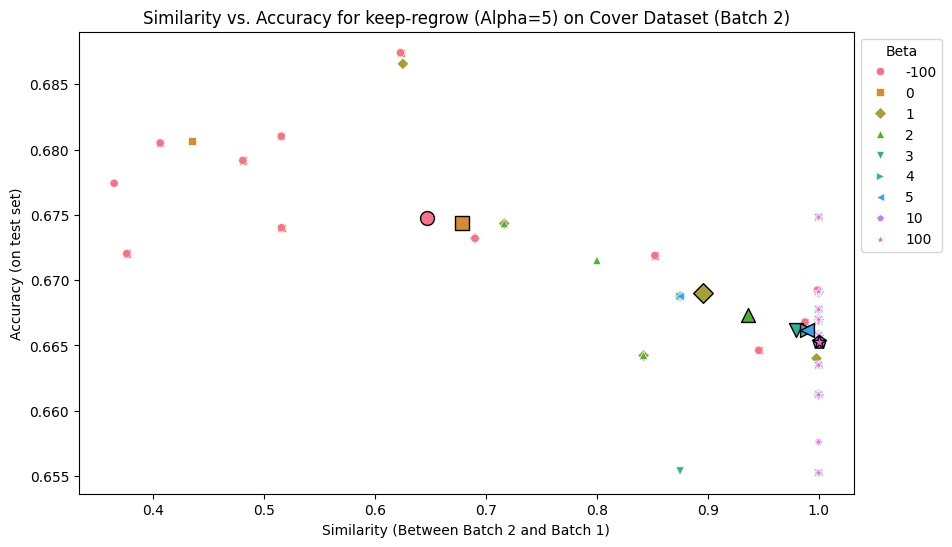

In [10]:
# Get unique datafile names
# unique_datafiles = df['datafile'].unique()
# Use the same order as generated
unique_datafiles = ['Skin', 'Higgs', 'Susy', 'Hepmass', 'Poker', 'Cover']

# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[(df['algorithm'] == 'keep-regrow') &
                     (df['datafile'] == datafile) &
                     (df['alpha'] == 5) &
                     (df['batch'] == 2)
                    ]

    # Calculate the group averages
    grouped = filtered_df.groupby('beta').agg({'acc': 'mean', 'similarity': 'mean'}).reset_index()

    # Create a custom palette with distinct colors
    custom_palette = sns.color_palette("husl", len(filtered_df['beta'].unique()))

    # Create a custom list of markers for distinct symbols
    markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*']

    # Create the scatter plot with distinct colors and symbols
    plt.figure(figsize=(10, 6))
    sns.scatterplot(y='acc', x='similarity', hue='beta', style='beta', markers=markers, palette=custom_palette, data=filtered_df)
    plt.title(f'Similarity vs. Accuracy for keep-regrow (Alpha=5) on {datafile} Dataset (Batch 2)')
    plt.ylabel('Accuracy (on test set)')
    plt.xlabel('Similarity (Between Batch 2 and Batch 1)')
    plt.legend(title='Beta', loc='upper left', bbox_to_anchor=(1, 1))

    # Plot the group averages as symbols
    for index, row in grouped.iterrows():
        plt.scatter(row['similarity'], row['acc'], marker=markers[index], s=100, color=custom_palette[index], edgecolor='black', linewidth=1)

    plt.show()


## Exploration of Algorithm

The visualisations in this section explore the tradeoff between accuracy (for batch 2, on the test set), number of nodes (for batch 2), and similarity (between the trees for batch 2 and batch 1) for different algorithms.

Keep-regrow falls between re-training (tree-retrain) and keeping the original decision tree from the first batch (keep-regrow_5-100) in terms of number of nodes, similarity, and accuracy.

Compared to EFDT (which is designed for computational efficiency rather than accuracy), keep-regrow has more nodes and higher accuracy. EFDT often has a high similarity (due to it's incremental nature), but on some datasets (Skin, Cover), keep-regrow has a higher similarity than EFDT

Based on the results, we conclude that keep-regrow offers a unique option in terms of the trade-off between number of nodes, accuracy, and similarity.

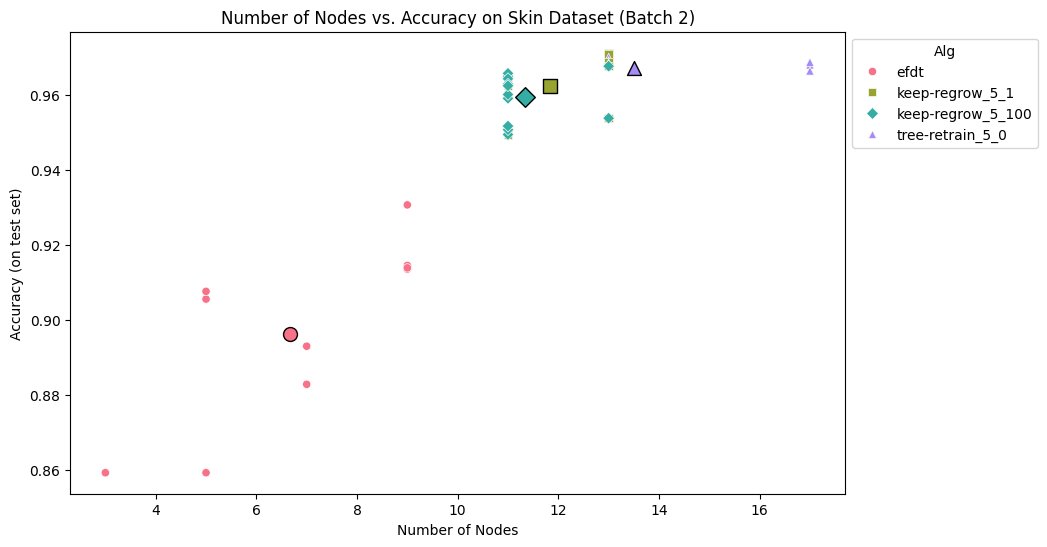

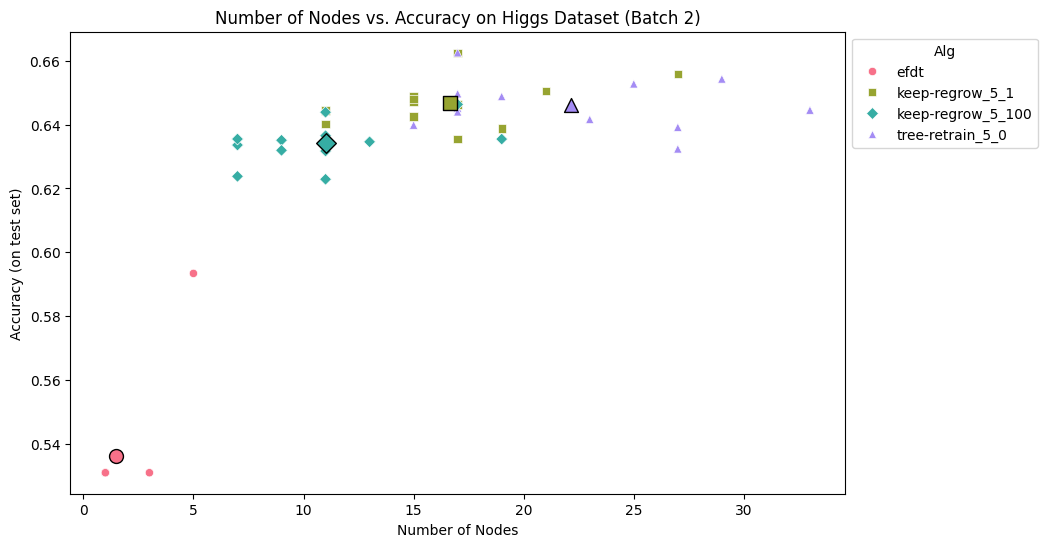

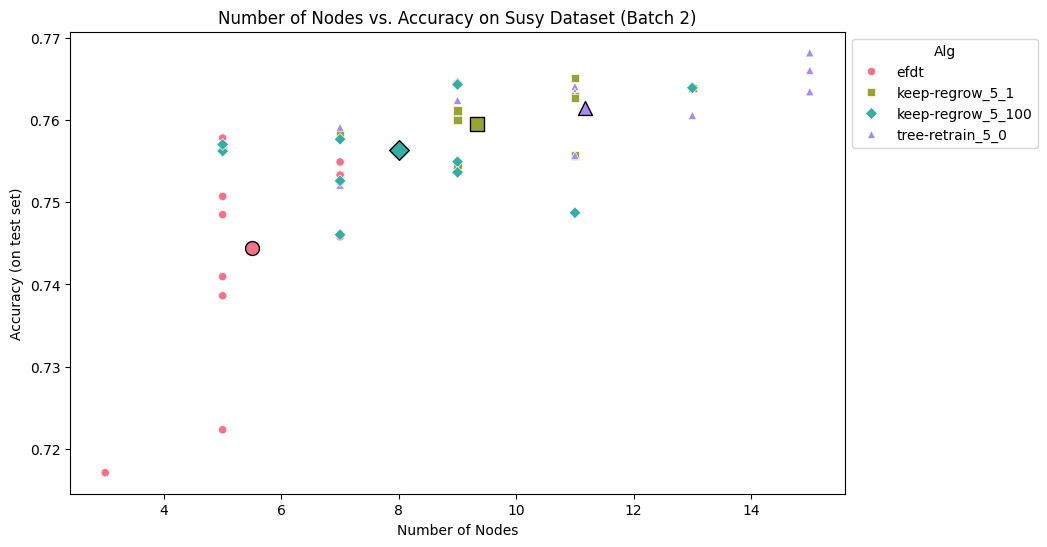

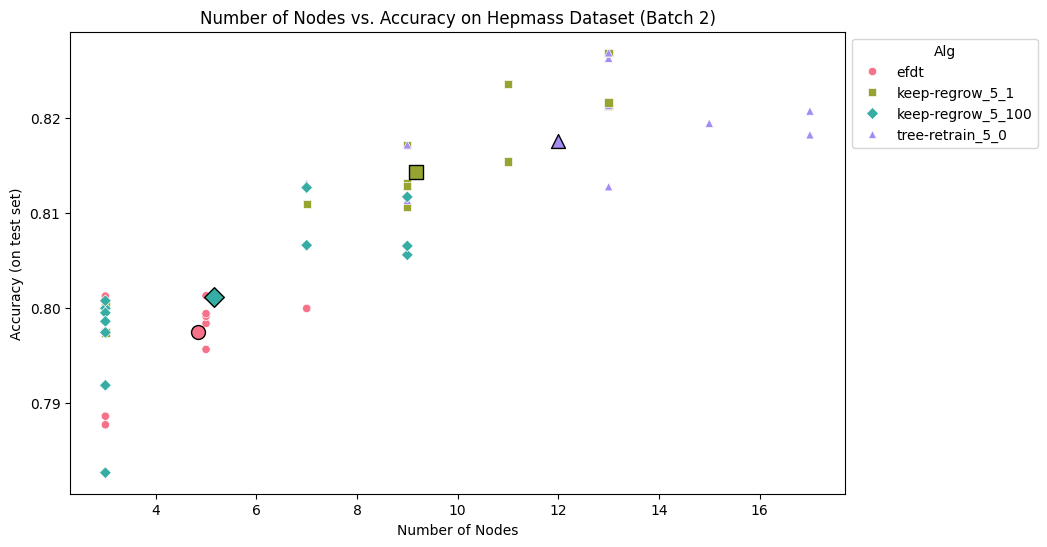

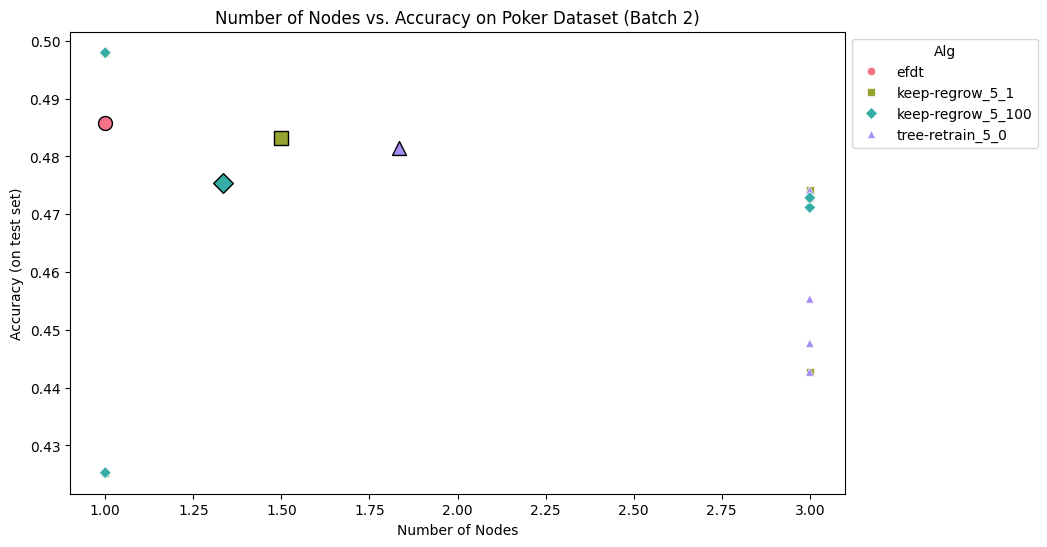

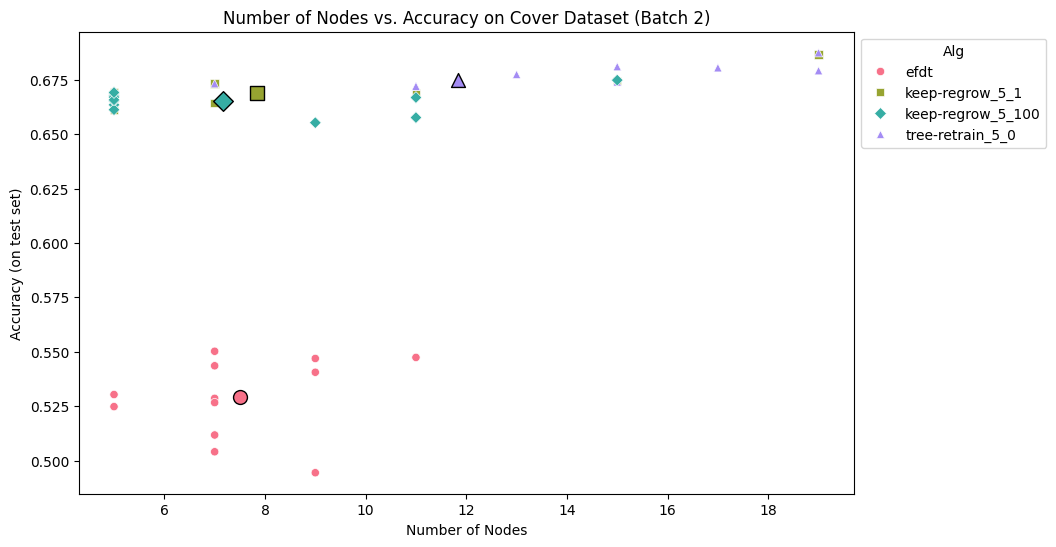

In [11]:
# Get unique datafile names
# unique_datafiles = df['datafile'].unique()
# Use the same order as generated
unique_datafiles = ['Skin', 'Higgs', 'Susy', 'Hepmass', 'Poker', 'Cover']

# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[df['alg'].isin(['efdt', 'keep-regrow_5_1', 'tree-retrain_5_0', 'keep-regrow_5_100']) &
                     (df['datafile'] == datafile) &
                     (df['batch'] == 2)
                    ]

    # Calculate the group averages
    grouped = filtered_df.groupby('alg').agg({'acc': 'mean', 'nodes': 'mean'}).reset_index()


    # Order of appearance of algorithms in the dataframe
    hue_order = grouped['alg'].unique()

    # Create a custom palette with distinct colors
    custom_palette = sns.color_palette("husl", len(filtered_df['alg'].unique()))

    # Create a custom list of markers for distinct symbols
    markers = ['o', 's', 'D', '^', 'v', '>', '<']
    alg_marker_mapping = {alg: markers[i] for i, alg in enumerate(hue_order)}

    # Create the scatter plot with distinct colors and symbols
    plt.figure(figsize=(10, 6))
    sns.scatterplot(y='acc', x='nodes', hue='alg', style='alg',markers=alg_marker_mapping, palette=custom_palette, data=filtered_df, hue_order=hue_order)
    plt.title(f'Number of Nodes vs. Accuracy on {datafile} Dataset (Batch 2)')
    plt.ylabel('Accuracy (on test set)')
    plt.xlabel('Number of Nodes')
    plt.legend(title='Alg', loc='upper left', bbox_to_anchor=(1, 1))

    # Plot the group averages as symbols
    for index, row in grouped.iterrows():
        plt.scatter(row['nodes'], row['acc'], marker=alg_marker_mapping[row['alg']], s=100, color=custom_palette[index], edgecolor='black', linewidth=1)

    plt.show()

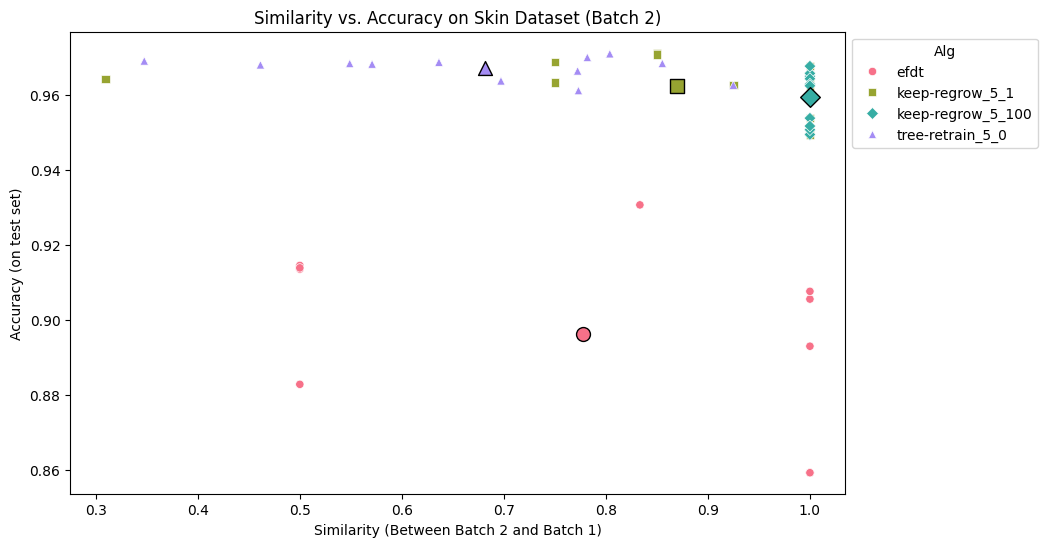

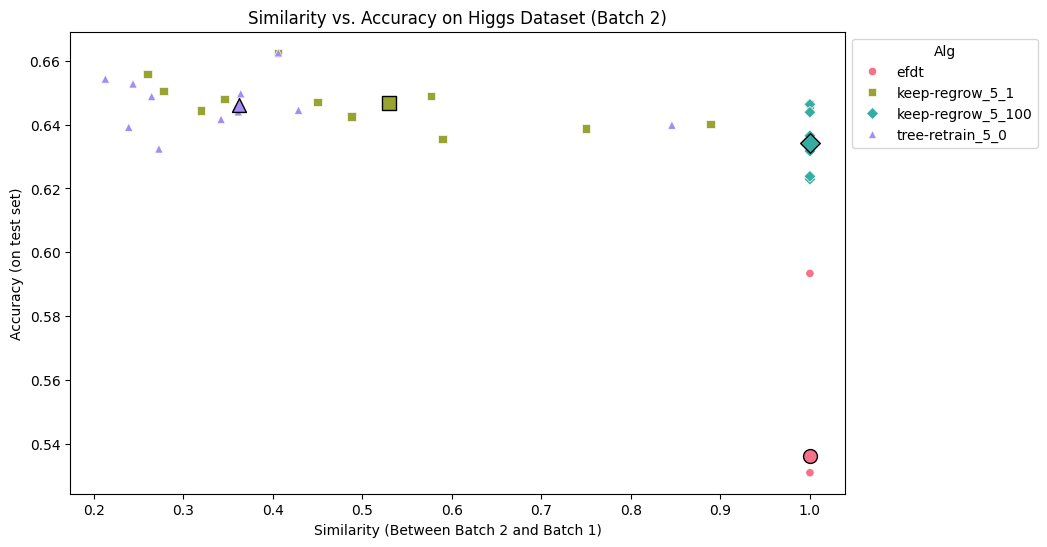

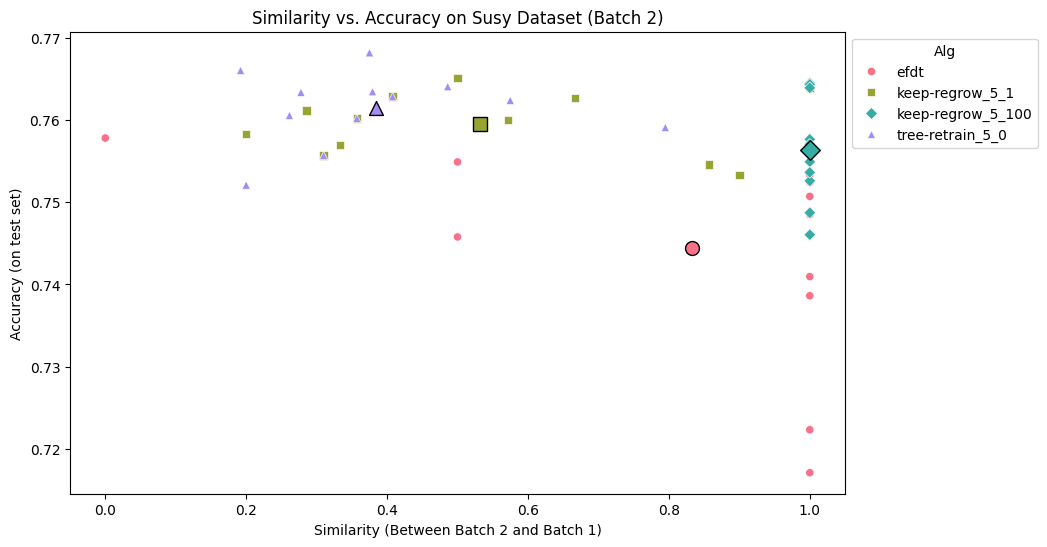

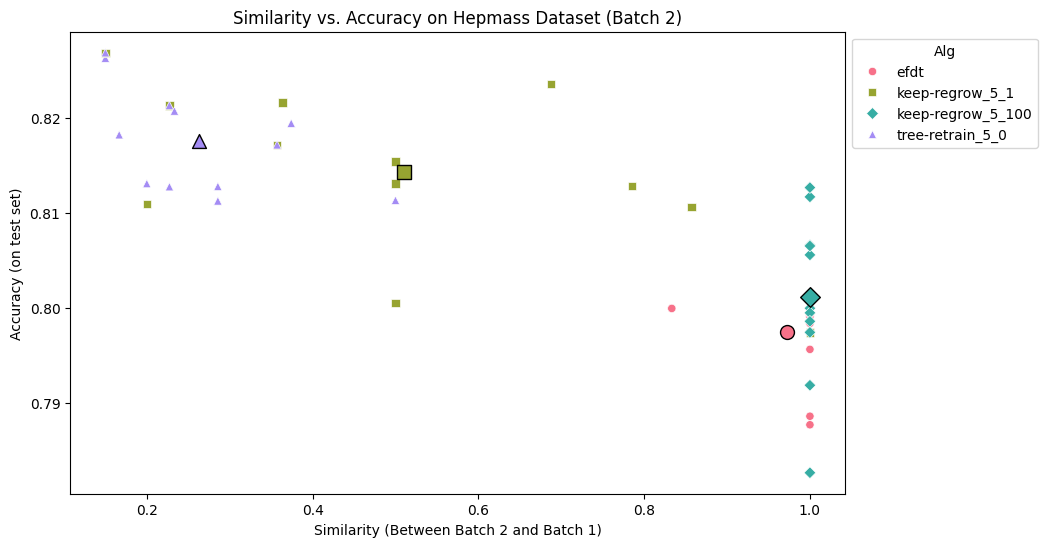

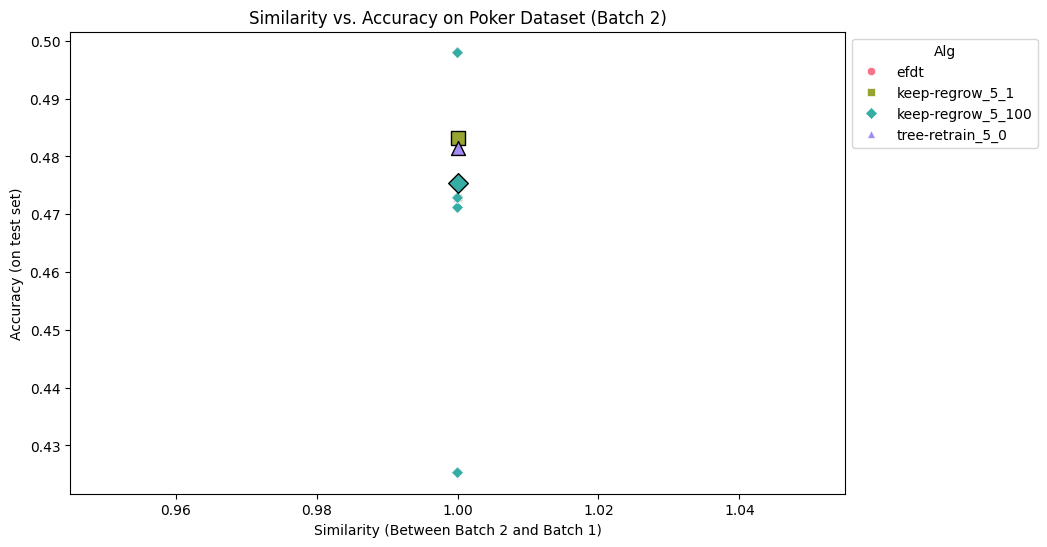

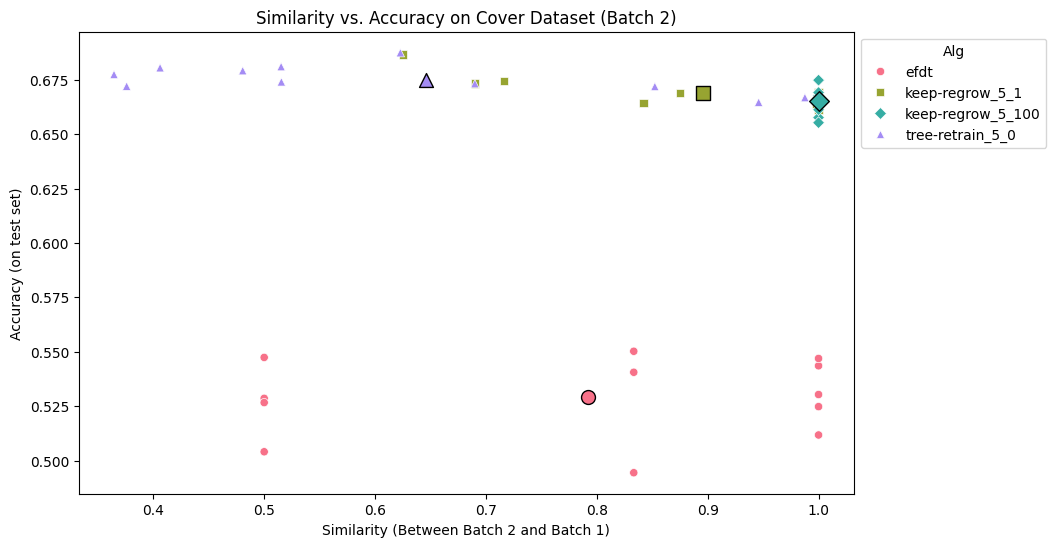

In [12]:
# Get unique datafile names
# unique_datafiles = df['datafile'].unique()
# Use the same order as generated
unique_datafiles = ['Skin', 'Higgs', 'Susy', 'Hepmass', 'Poker', 'Cover']

# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[df['alg'].isin(['efdt', 'keep-regrow_5_1', 'tree-retrain_5_0', 'keep-regrow_5_100']) &
                     (df['datafile'] == datafile) &
                     (df['batch'] == 2)
                    ]

    # Calculate the group averages
    grouped = filtered_df.groupby('alg').agg({'acc': 'mean', 'similarity': 'mean'}).reset_index()


    # Order of appearance of algorithms in the dataframe
    hue_order = grouped['alg'].unique()

    # Create a custom palette with distinct colors
    custom_palette = sns.color_palette("husl", len(filtered_df['alg'].unique()))

    # Create a custom list of markers for distinct symbols
    markers = ['o', 's', 'D', '^', 'v', '>', '<']
    alg_marker_mapping = {alg: markers[i] for i, alg in enumerate(hue_order)}

    # Create the scatter plot with distinct colors and symbols
    plt.figure(figsize=(10, 6))
    sns.scatterplot(y='acc', x='similarity', hue='alg', style='alg',markers=alg_marker_mapping, palette=custom_palette, data=filtered_df, hue_order=hue_order)
    plt.title(f'Similarity vs. Accuracy on {datafile} Dataset (Batch 2)')
    plt.ylabel('Accuracy (on test set)')
    plt.xlabel('Similarity (Between Batch 2 and Batch 1)')
    plt.legend(title='Alg', loc='upper left', bbox_to_anchor=(1, 1))

    # Plot the group averages as symbols
    for index, row in grouped.iterrows():
        plt.scatter(row['similarity'], row['acc'], marker=alg_marker_mapping[row['alg']], s=100, color=custom_palette[index], edgecolor='black', linewidth=1)

    plt.show()

# Exploration of behaviour over time

The visualisations in this section explore the accuracy (for batch 1-10, on the test set), number of nodes (for batch 1-10), and similarity (between the trees for batch 2vs1, 3vs2, 4vs3, ..., 10vs9) for different algorithms.

We can see that over time (each batch update), keep-regrow is able to perform similarly to re-training while having a higher similarity.

In the plots of behaviour over time, it is obvious that keeping the original tree (keep-regrow_5_100) is not a good strategy despite 100% similarity, is it doesn't allow learning over time.

We can also see that even after 10 batches (1,000 x 10 = 10,000 datapoints), the EFDT algorithm has a lower accuracy than keep-regrow traind on a single batch (1,000 points). On certain batches EFDT also has a very low similarity (e.g. due to changing the root node), whereas in the experiments, keep-regrow always has a greater than 0 similarity.

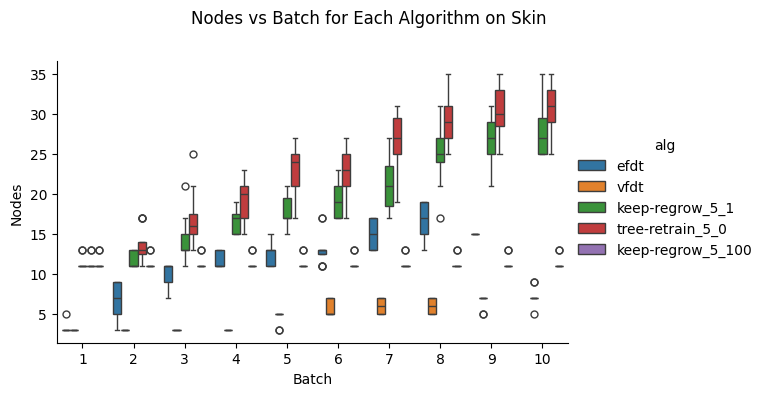

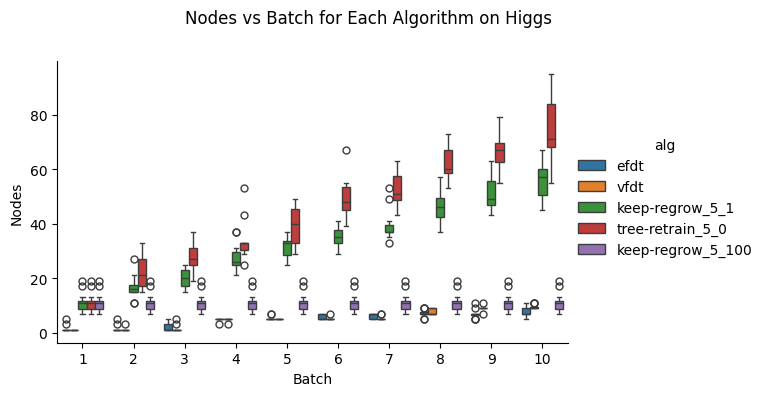

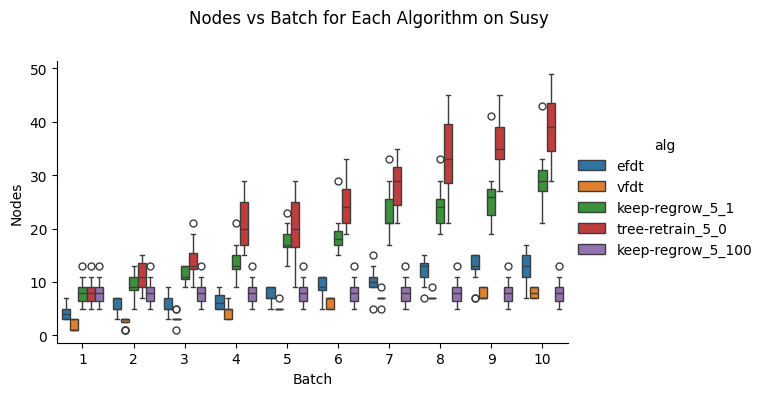

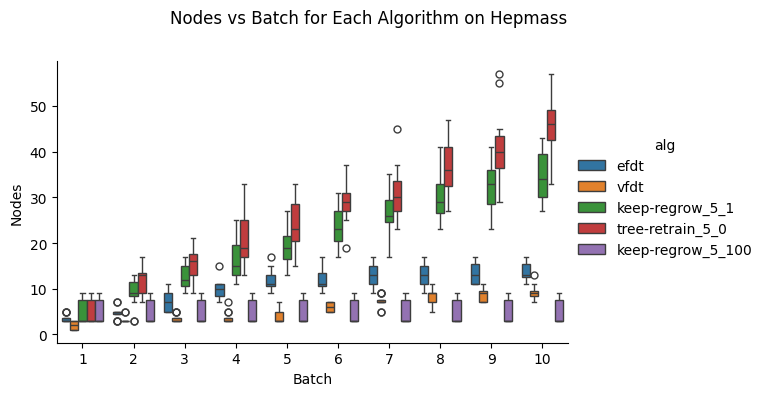

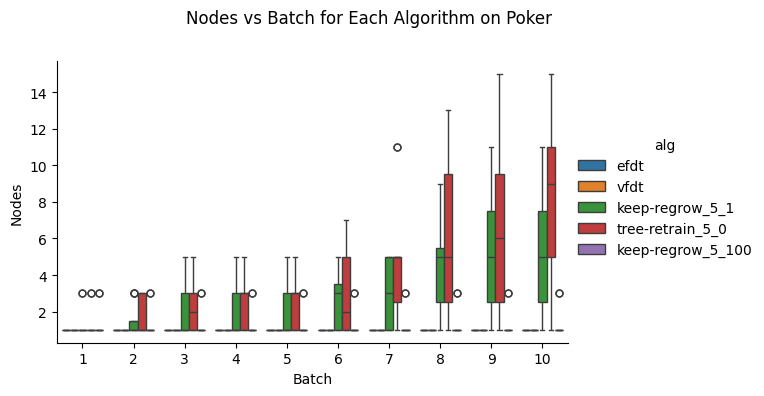

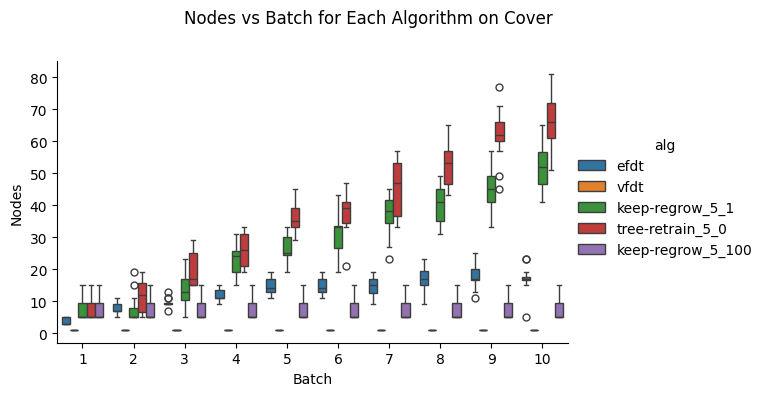

In [13]:
# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[df['alg'].isin(['efdt', 'vfdt', 'keep-regrow_5_1', 'tree-retrain_5_0', 'keep-regrow_5_100']) &
                     (df['datafile'] == datafile)
                    ]

    # Create a figure with subplots for each 'alg' value
    g = sns.catplot(
        data=filtered_df, x="batch", y="nodes",
        hue="alg",
        kind="box", height=4, aspect=1.5,
    )

    # Set axis labels and titles
    g.set_axis_labels("Batch", "Nodes")

    # Add a title
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Nodes vs Batch for Each Algorithm on {datafile}")

    # Show the plot
    plt.show()

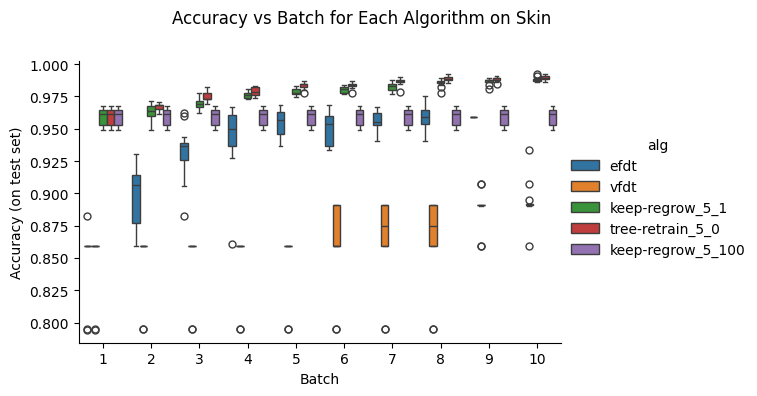

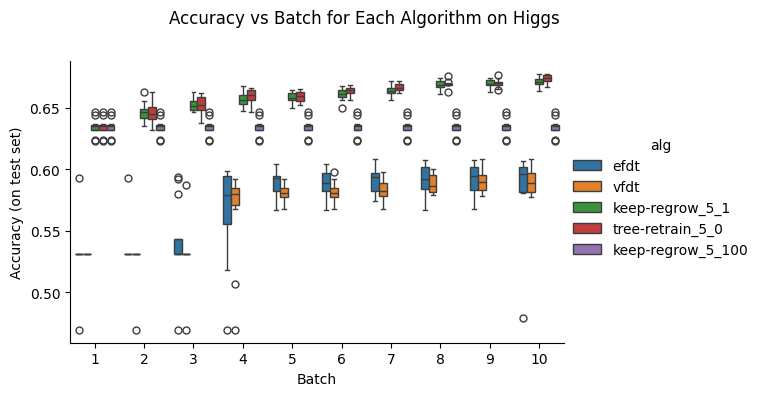

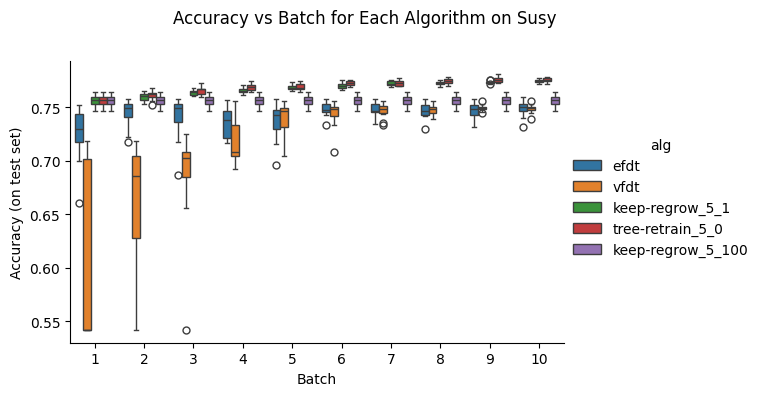

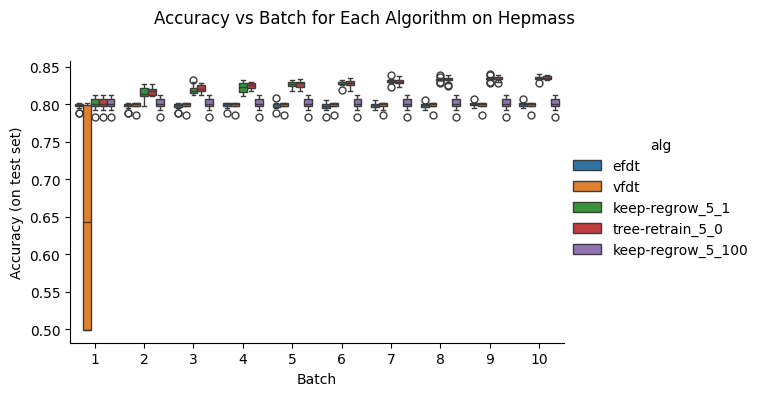

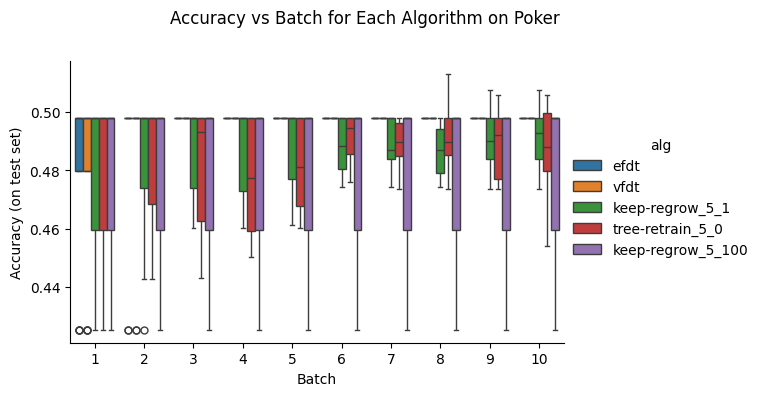

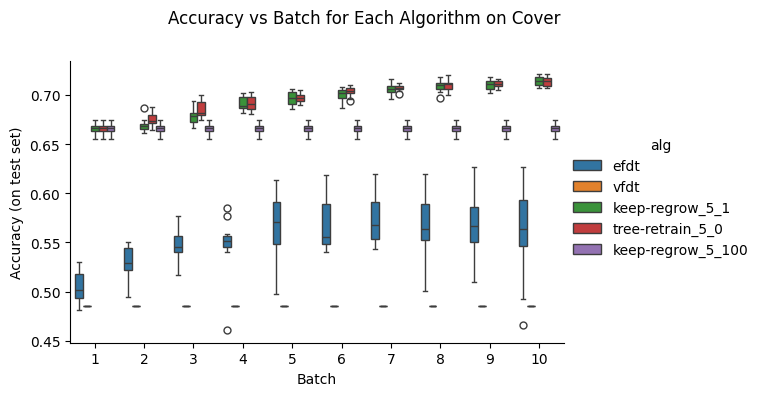

In [14]:
# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[df['alg'].isin(['efdt', 'vfdt', 'keep-regrow_5_1', 'tree-retrain_5_0', 'keep-regrow_5_100']) &
                     (df['datafile'] == datafile)
                    ]

    # Create a figure with subplots for each 'alg' value
    g = sns.catplot(
        data=filtered_df, x="batch", y="acc",
        hue="alg",
        kind="box", height=4, aspect=1.5,
    )

    # Set axis labels and titles
    g.set_axis_labels("Batch", "Accuracy (on test set)")

    # Add a title
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Accuracy vs Batch for Each Algorithm on {datafile}")

    # Show the plot
    plt.show()

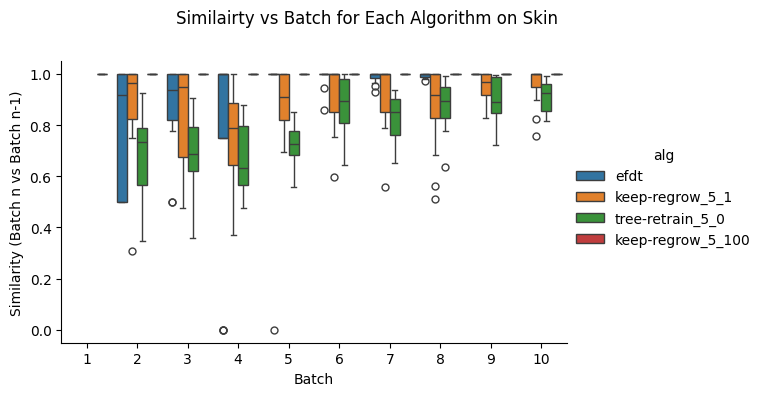

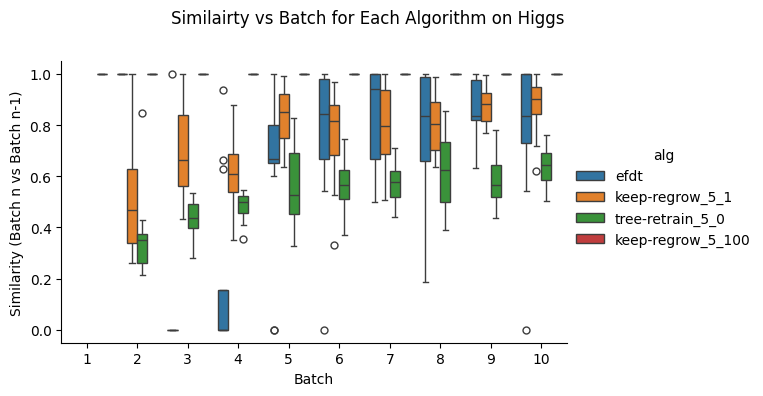

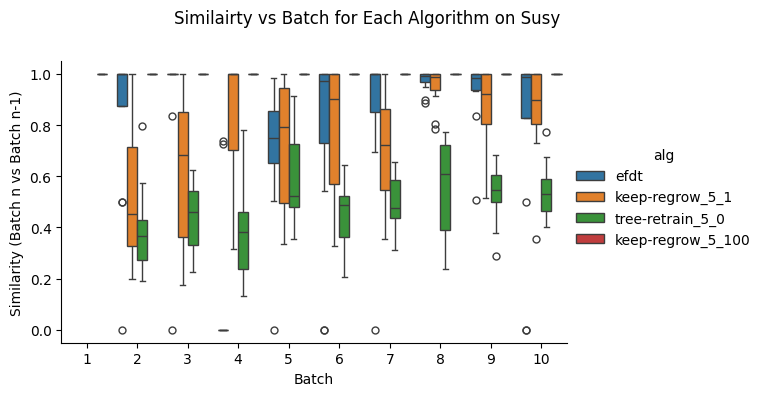

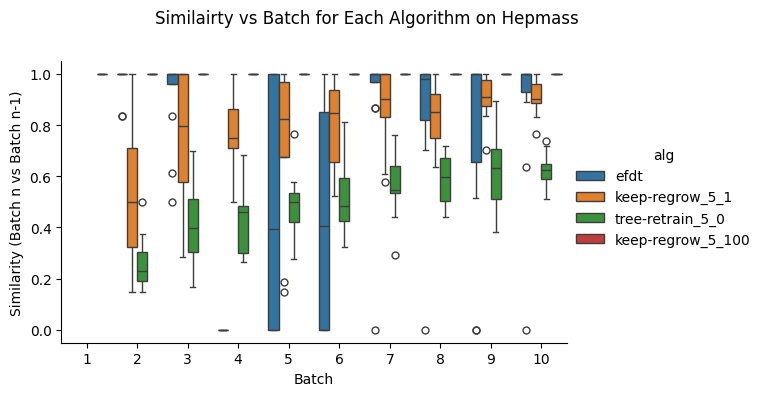

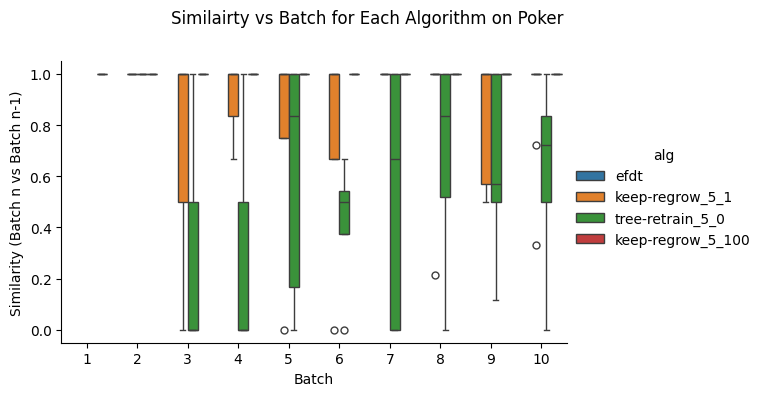

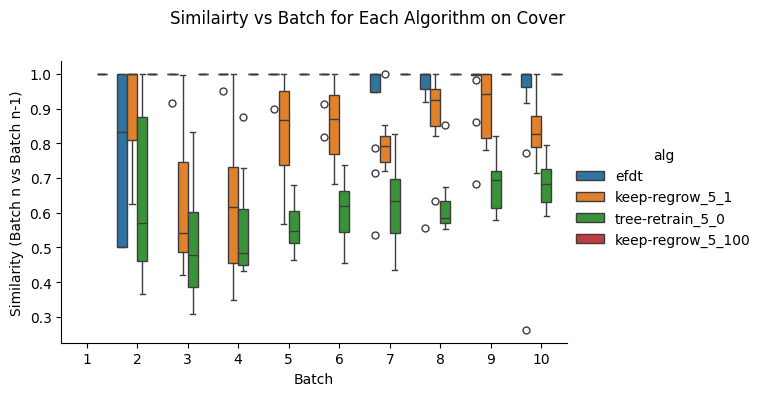

In [15]:
# Loop through each unique datafile and create a separate plot
for datafile in unique_datafiles:
    # Filter the data for the desired conditions
    filtered_df = df[df['alg'].isin(['efdt', 'keep-regrow_5_1', 'tree-retrain_5_0', 'keep-regrow_5_100']) &
                     (df['datafile'] == datafile)
                    ]

    # Create a figure with subplots for each 'alg' value
    g = sns.catplot(
        data=filtered_df, x="batch", y="similarity",
        hue="alg",
        kind="box", height=4, aspect=1.5,
    )

    # Set axis labels and titles
    g.set_axis_labels("Batch", "Similarity (Batch n vs Batch n-1)")

    # Add a title
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Similairty vs Batch for Each Algorithm on {datafile}")

    # Show the plot
    plt.show()